Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Friday, October 9, 2015.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Question 1

The data below provides counts of a flour beetle (Tribolium confusum) population at various points in time:

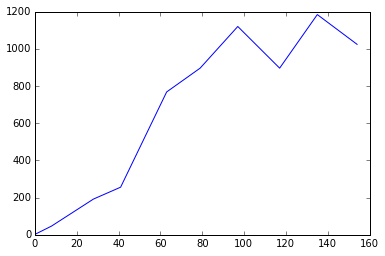

In [3]:
days = 0,8,28,41,63,79,97,117,135,154
beetles = 2,47,192,256,768,896,1120,896,1184,1024

plt.plot(days, beetles)

An elementary model for population growth is the logistic model:

$$\frac{dN}{dt} = rN\left(1 - \frac{N}{K}\right)$$

where $N$ is population size, $t$ is time, $r$ is a growth rate parameter, and $K$ is a parameter that represents the population carrying capacity of the environment. The solution to this differential equation is given by: 

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

where $N_t$ denotes the population size at time $t$. 

1. Fit the logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors between model predictions and observed counts.

2. In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. Find the MLEs under this assumption, and provide estimates of standard errors and correlation between them.

## Question 2

1. Implement simulated annealing for minimizing the AIC for the baseball salary regression problem. Model your algorithm on the example given in class. 

    1. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).  
    2. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

2. Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem. Model your algorithm on Example 3.5. 

    1. Compare the effects of using different mutation rates.  
    2. Compare the effects of using different generation sizes.  
    3. Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.



In [4]:
baseball = pd.read_table('../data/textbook/baseball.dat', sep='\s+')

## Question 3

Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities described in the lecture notes, using minimum total distance as the criterion. Use the the first city listed in the dataset as "home" (*i.e.* the trip must start and end there. I will award 5 bonus points to the best solution!

In [3]:
def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

cities =  pd.read_csv('../data/brasil_capitals.txt', 
                      names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon)

## Question 4

Suppose $y$ has a binomial distribution with parameters $n$ and $p$, and we are interested in the log-odds value $\theta = \log(p/(1 − p))$. Our prior for $\theta$ is that $\theta \sim N(\mu, \sigma^2)$. It follows that the posterior density of $\theta$ is given, up to a proportionality constant, by:

$$\pi(\theta | y) \propto \frac{\exp(y\theta)}{(1 + exp(\theta))^n} \exp\left[\frac{-(\theta − \mu)^2}{2\sigma^2}\right]$$

For example, suppose we are interested in learning about the probability that a possibly-biased coin lands heads when tossed. *A priori* we believe that the coin is fair, so we assign $\theta$ a $N(0,.25)$ prior. We toss the coin $n = 5$ times and obtain $y = 5$ heads.

1. Using a normal approximation to the posterior density, compute the probability that the coin is biased toward heads (i.e., that θ is posi- tive).
2. Using the prior density as a proposal density, design a rejection algo- rithm for sampling from the posterior distribution. Using simulated draws from your algorithm, approximate the probability that the coin is biased toward heads.
3. Using the prior density as a proposal density, simulate values from the posterior distribution using the SIR algorithm. Approximate the probability that the coin is biased toward heads.